In [1]:
import pickle
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import matplotlib.patches as patches
import os
plt.rcParams['font.family'] = 'Times New Roman'
np.random.seed(42)
############################################################################################################

############################################################################################################
def detect_outliers_iqr(data, column):
    """使用IQR检测离群点并将其用NaN填充"""
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # 用NaN填充离群点
    data[f'{column}_outlier'] = data[column]
    data.loc[(data[column] < lower_bound) | (data[column] > upper_bound), f'{column}_outlier'] = np.nan
    
    return data
############################################################################################################

############################################################################################################
def generateNorm(mean, std):
    a, b = (-std - mean) / std, (std - mean) / std
    random_value = stats.truncnorm(a, b, loc=mean, scale=std).rvs()
    return  random_value
############################################################################################################

############################################################################################################
def plotDistribution(data, x_col, y_col):
    data_mean = data[y_col].mean()
    data_std = data[y_col].std()
    x_values = np.linspace(data_mean - 4 * data_std, data_mean + 4 * data_std, 1000)
    y_values = stats.norm.pdf(x_values, data_mean, data_std)
    conf_interval = stats.norm.interval(0.95, loc=data_mean, scale=data_std)

    fig, ax = plt.subplots(figsize=(12, 7))
    ax.hist(data[y_col], bins=30, color='skyblue', edgecolor='black', density=True, linewidth=1.2)
    ax.plot(x_values, y_values, label='Normal Distribution', color='blue')
    ax.fill_between(x_values, y_values, where=(x_values >= conf_interval[0]) & (x_values <= conf_interval[1]), color='lightgreen', alpha=0.5, label='95% Confidence Interval')
    ax.axvline(conf_interval[0], color='green', linestyle='dashed', linewidth=1.5, label=f'95% CI Lower: {conf_interval[0]:.4f}')
    ax.axvline(conf_interval[1], color='green', linestyle='dashed', linewidth=1.5, label=f'95% CI Upper: {conf_interval[1]:.4f}')
    
    ax.axvline(data_mean, color='red', linestyle='dashed', linewidth=1.5, label=f'Mean: {data_mean:.4f}')
    ax.axvline(data_mean + data_std, color='orange', linestyle='dashed', linewidth=1.5, label=f'Std Dev: +{data_std:.4f}')
    ax.axvline(data_mean - data_std, color='orange', linestyle='dashed', linewidth=1.5, label=f'Std Dev: -{data_std:.4f}')
    
    ax.set_xlabel('Time Difference Values', fontsize=12, fontweight='bold')
    ax.set_ylabel('Density', fontsize=12, fontweight='bold')
    ax.set_title('Distribution of Time Difference Values with Normal Distribution', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    plt.tight_layout()
    plt.show()

    stats_dict = {
        'mean': data_mean,
        'std': data_std,
        'Lower': conf_interval[0],
        'Upper': conf_interval[1]
    }
    return fig, ax, stats_dict
############################################################################################################

############################################################################################################
def predictLifespan(data, y_label, lifeDeclineInd = 0.1, stand_value = None):
    x_ticks = np.arange(len(data))
    if stand_value is None:
        stand_value = data.iloc[:10][y_label].mean()
    
    X = x_ticks
    y = data[y_label].values
    LR = LinearRegression(fit_intercept=True)
    LR.fit(X.reshape(-1,1), y)
    step_0 = X[-1] + 1
    step_1 = step_0 + 10
    in1 = 0
    while True:
        pred_range = np.arange(step_0, step_1)

        LR_pred = LR.predict(pred_range.reshape(-1, 1))
        if (stand_value - LR_pred[-1]) / stand_value > lifeDeclineInd or in1 > 30000:

            break
        else:
            step_1 = pred_range[-1] + 10
            in1 += 10

    result = np.concatenate((y, LR_pred))
    decay_period_years = step_1 / 365
    if in1>30000:
        return None, None
    return result, decay_period_years, LR.predict(x_ticks.reshape(-1, 1))
############################################################################################################

############################################################################################################
def getDailyDataset(filePath, saveProcess = False):
	with open(filePath + '/rawdata.pkl', 'rb') as f:
		data = pickle.load(f)
	first_non_nan_index = data['y'].first_valid_index()
	data = data.loc[first_non_nan_index:].reset_index(drop=True)
	data.loc[data['y'] < 65, 'y'] = None	

	data['ds'] = data['ds'].dt.date
	date_unique = data['ds'].unique()
	date_seq = pd.date_range(start=date_unique[0], end=date_unique[-1], freq='1D')

	new_data_list = []
	for date in date_seq:
		idx = data[data['ds'] == date.date()].index
		if not idx.empty:
			daily_data = detect_outliers_iqr(data.loc[idx], 'y')
			mean_y = daily_data['y_outlier'].mean()
			new_data_list.append({'ds': date ,'y':mean_y})
		else:
			mean_y = None
			new_data_list.append({'ds': date ,'y':mean_y,})

	new_data_df = pd.DataFrame(new_data_list)
	new_data_df['y'] = new_data_df['y'].astype(float).interpolate(method = 'linear')
	if saveProcess:
		with open(filePath + '/dailyData.pkl', 'wb') as f:
			pickle.dump(new_data_df, f)
	return new_data_df
############################################################################################################

In [2]:
fileName = 'No.3'
filePath = f'./data/{fileName}'
saveFig = False
if saveFig:
	figPath = f'./figure/{fileName}/'
	os.makedirs(figPath, exist_ok=True)
data = getDailyDataset(filePath, saveProcess= True)
data = data[:-29].reset_index(drop=True)
# no8 74.126
data['diff'] = data['y'].diff()

y_min = np.floor(data['y'].min())
y_max = np.ceil(data['y'].max())

y_diff_min = np.floor(data['diff'].min())
y_diff_max = np.ceil(data['diff'].max())
data


,ds,y,diff
0,2024-01-11,142.842874,NaN
1,2024-01-12,142.840522,-0.002352
2,2024-01-13,142.864779,0.024257
3,2024-01-14,142.904144,0.039365
4,2024-01-15,142.998887,0.094743
...,...,...,...
133,2024-05-23,142.904194,-0.013535
134,2024-05-24,142.904330,0.000136
135,2024-05-25,142.899776,-0.004554
136,2024-05-26,142.896440,-0.003336


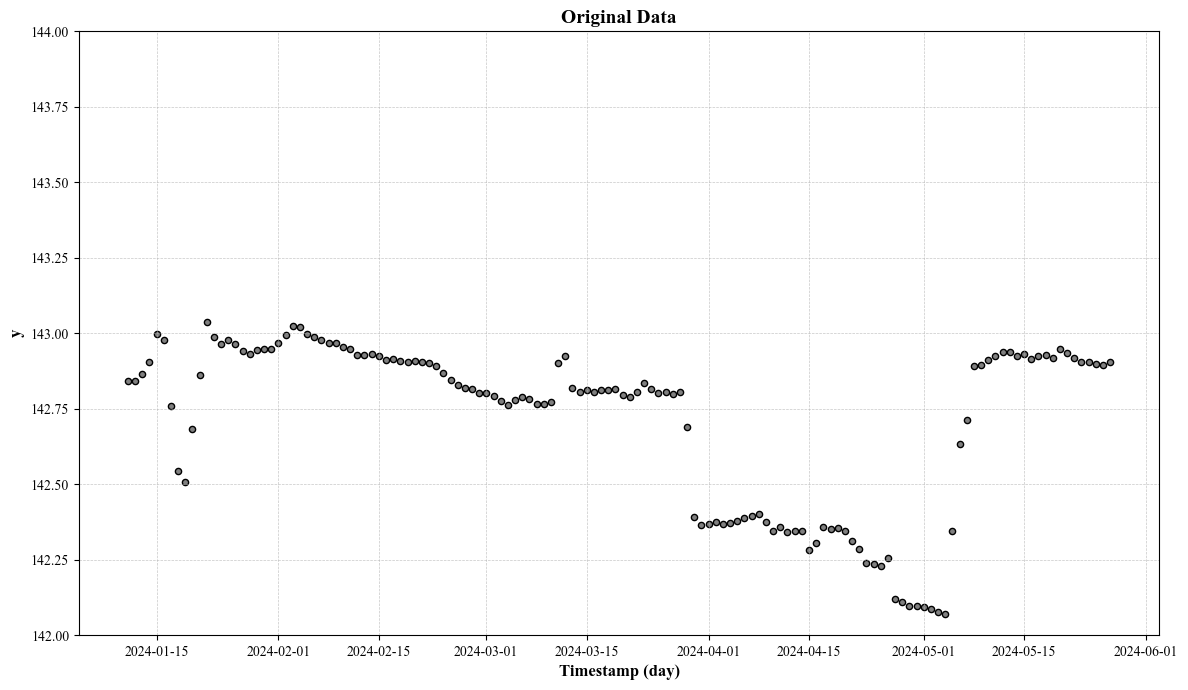

In [3]:
fig0, ax0 = plt.subplots(figsize=(12, 7))
ax0.scatter(data['ds'], data['y'], marker='o', facecolors='gray', edgecolors='black', alpha=1, s=20)
ax0.set_xlabel('Timestamp (day)', fontsize=12,fontweight='bold')
ax0.set_ylabel('y', fontsize=12,fontweight='bold')
ax0.set_title('Original Data', fontsize=14, fontweight='bold')
ax0.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
ax0.set_ylim(y_min, y_max)
plt.tight_layout()
if saveFig:
	fig0.savefig(f'{figPath}fig0.png', dpi=300)
plt.show() 

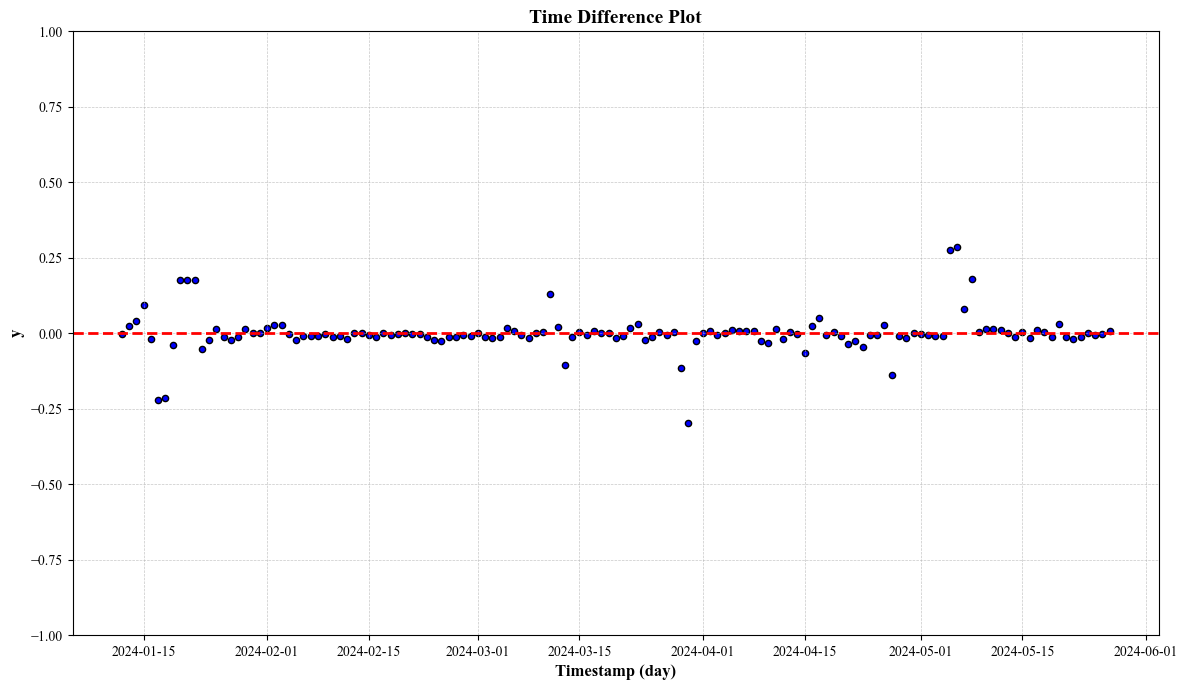

In [4]:
fig1, ax1 = plt.subplots(figsize=(12, 7))
ax1.scatter(data['ds'], data['diff'], marker='o', facecolors='blue', edgecolors='black', alpha=1, s=20)
ax1.axhline(y=0, color='red', linestyle='--', linewidth=2)
ax1.set_xlabel('Timestamp (day)', fontsize=12,fontweight='bold')
ax1.set_ylabel('y', fontsize=12,fontweight='bold')
ax1.set_title('Time Difference Plot', fontsize=14, fontweight='bold')
ax1.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
ax1.set_ylim(y_diff_min, y_diff_max)
plt.tight_layout()
if saveFig:
	fig1.savefig(f'{figPath}fig1.png', dpi=300)
plt.show() 

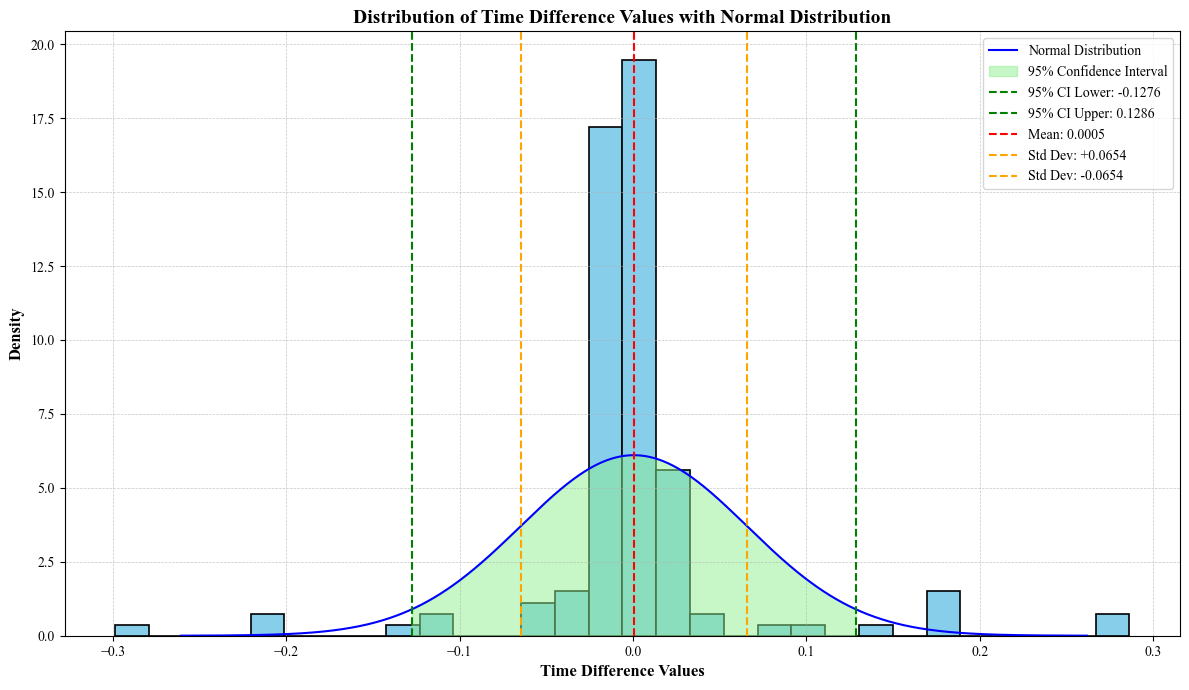


-------------------------------------
mean:  0.0004526910095676672
std:  0.06535726154415974
95% CI Lower:  -0.12764518774515013
95% CI Upper:  0.12855056976428544


In [5]:
fig2, ax2, stats_dict1 = plotDistribution(data, 'x', 'diff')
# ax2.set_xlim(y_diff_min, y_diff_max)
if saveFig:
	fig2.savefig(f'{figPath}fig2.png', dpi=300)

print('\n-------------------------------------')
print('mean: ', stats_dict1['mean'])
print('std: ', stats_dict1['std'])
print('95% CI Lower: ', stats_dict1['Lower'])
print('95% CI Upper: ', stats_dict1['Upper'])

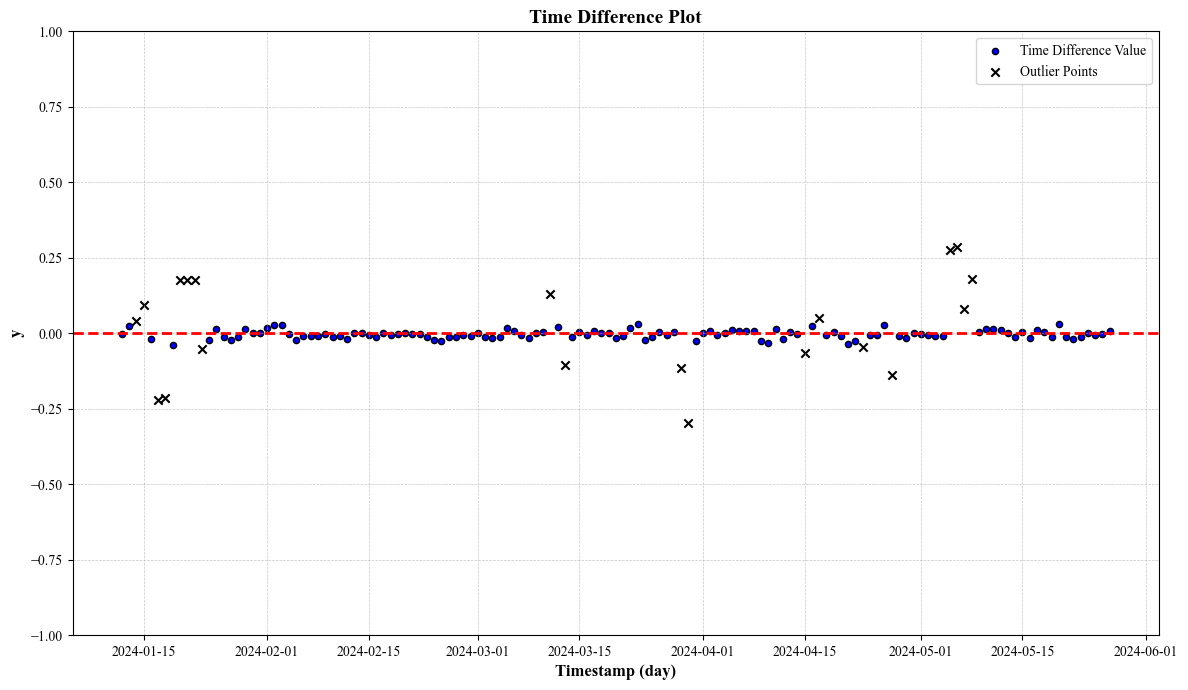

In [6]:
corrected_data = detect_outliers_iqr(data, 'diff')

nan_indices = corrected_data[corrected_data['diff_outlier'].isna()].index
nan_indices = nan_indices[1:]
non_nan_indices = corrected_data.index.difference(nan_indices)

fig3, ax3 = plt.subplots(figsize=(12, 7))
ax3.scatter(data['ds'].iloc[non_nan_indices], data['diff'].iloc[non_nan_indices], marker='o', facecolors='blue', edgecolors='black', alpha=1, s=20, label='Time Difference Value')
ax3.scatter(corrected_data['ds'].iloc[nan_indices], corrected_data['diff'].iloc[nan_indices], marker='x', color='black',alpha=1, label='Outlier Points')
ax3.axhline(y=0, color='red', linestyle='--', linewidth=2)
ax3.set_xlabel('Timestamp (day)', fontsize=12,fontweight='bold')
ax3.set_ylabel('y', fontsize=12,fontweight='bold')
ax3.set_title('Time Difference Plot', fontsize=14, fontweight='bold')
ax3.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
ax3.set_ylim(y_diff_min, y_diff_max)
ax3.legend()
plt.tight_layout()
if saveFig:
	fig3.savefig(f'{figPath}fig3.png', dpi=300)
plt.show() 

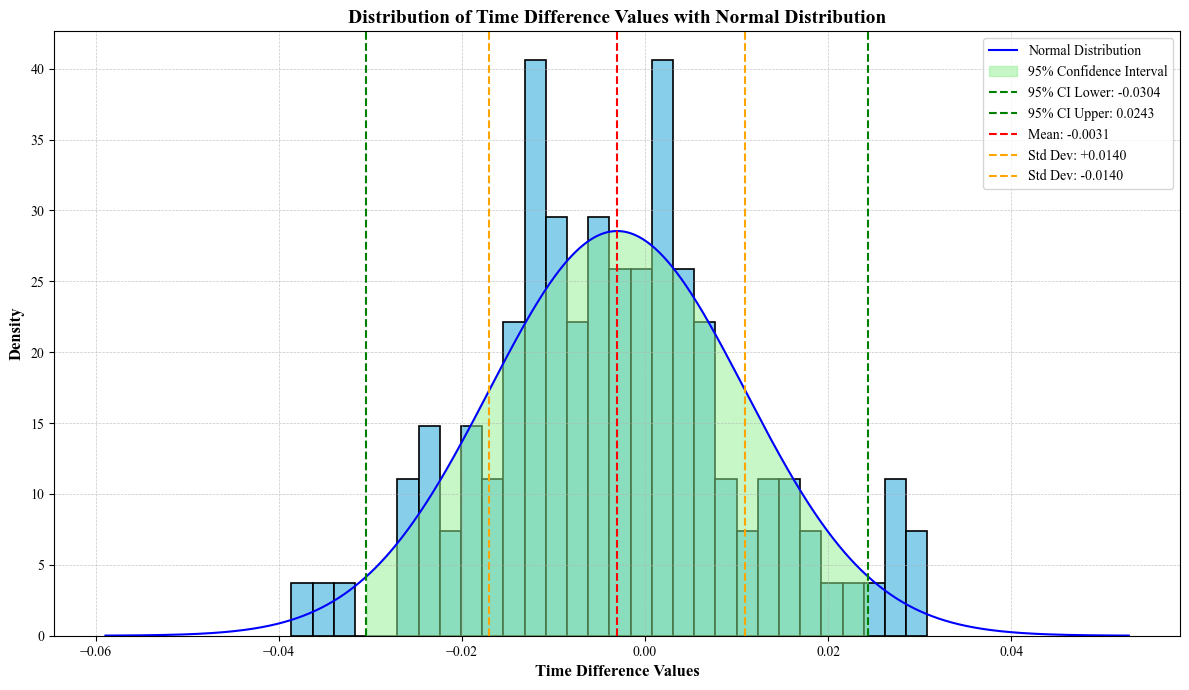


-------------------------------------
mean:  -0.0030501412371752665
std:  0.013973837932549858
95% CI Lower:  -0.030438360310772634
95% CI Upper:  0.024338077836422105


In [7]:
fig4, ax4, stats_dict2 = plotDistribution(corrected_data, 'x', 'diff_outlier')
# ax4.set_xlim(y_diff_min, y_diff_max)
if saveFig:
	fig4.savefig(f'{figPath}fig4.png', dpi=300)

print('\n-------------------------------------')
print('mean: ', stats_dict2['mean'])
print('std: ', stats_dict2['std'])
print('95% CI Lower: ', stats_dict2['Lower'])
print('95% CI Upper: ', stats_dict2['Upper'])

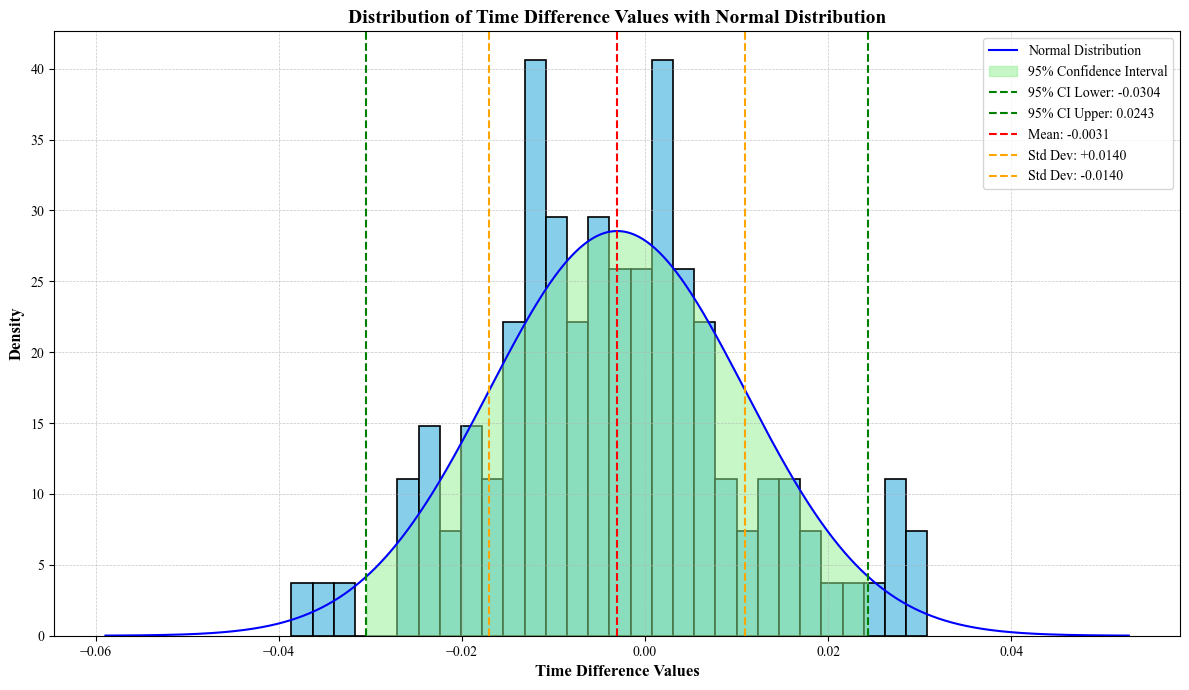

In [8]:
fig5, ax5, _ = plotDistribution(corrected_data, 'x', 'diff_outlier')
arrow_y_position = 10 # 调高箭头位置
arrowprops = dict(facecolor='red', edgecolor='black', linewidth=1.5, mutation_scale=30)

left_arrow = patches.FancyArrowPatch((stats_dict2['mean'], arrow_y_position), 
                                      (stats_dict2['mean'] - stats_dict2['std'], arrow_y_position), **arrowprops)
ax5.add_patch(left_arrow)
right_arrow = patches.FancyArrowPatch((stats_dict2['mean'], arrow_y_position), 
                                     (stats_dict2['mean'] + stats_dict2['std'], arrow_y_position), **arrowprops)
ax5.add_patch(right_arrow)
ax5.text(stats_dict2['mean'] - stats_dict2['std'] / 2, arrow_y_position+ 0.25, '1 Std', ha='center', va='bottom', fontsize=10, fontweight='bold')
ax5.text(stats_dict2['mean'] + stats_dict2['std'] / 2, arrow_y_position+0.25, '1 Std', ha='center', va='bottom', fontsize=10, fontweight='bold')
# ax5.set_xlim(y_diff_min, y_diff_max)
if saveFig:
	fig5.savefig(f'{figPath}fig5.png', dpi=300)

In [9]:
corrected_data['diff_outlier_filled'] = corrected_data['diff_outlier'].copy()
nan_indices = corrected_data.index[corrected_data['diff_outlier'].isna() & (corrected_data.index > 0)].tolist()
random_numbers = [generateNorm(stats_dict2['mean'], stats_dict2['std']) for _ in nan_indices]
for idx, rand_num in zip(nan_indices, random_numbers):
    corrected_data.at[idx, 'diff_outlier_filled'] = rand_num

corrected_data['y_corrected'] = corrected_data['diff_outlier_filled'].cumsum() + corrected_data['y'].iloc[0]
corrected_data.loc[0, 'y_corrected'] = corrected_data.loc[0, 'y']

with open(filePath + '/processDailyData.pkl', 'wb') as f:
    pickle.dump(corrected_data, f)

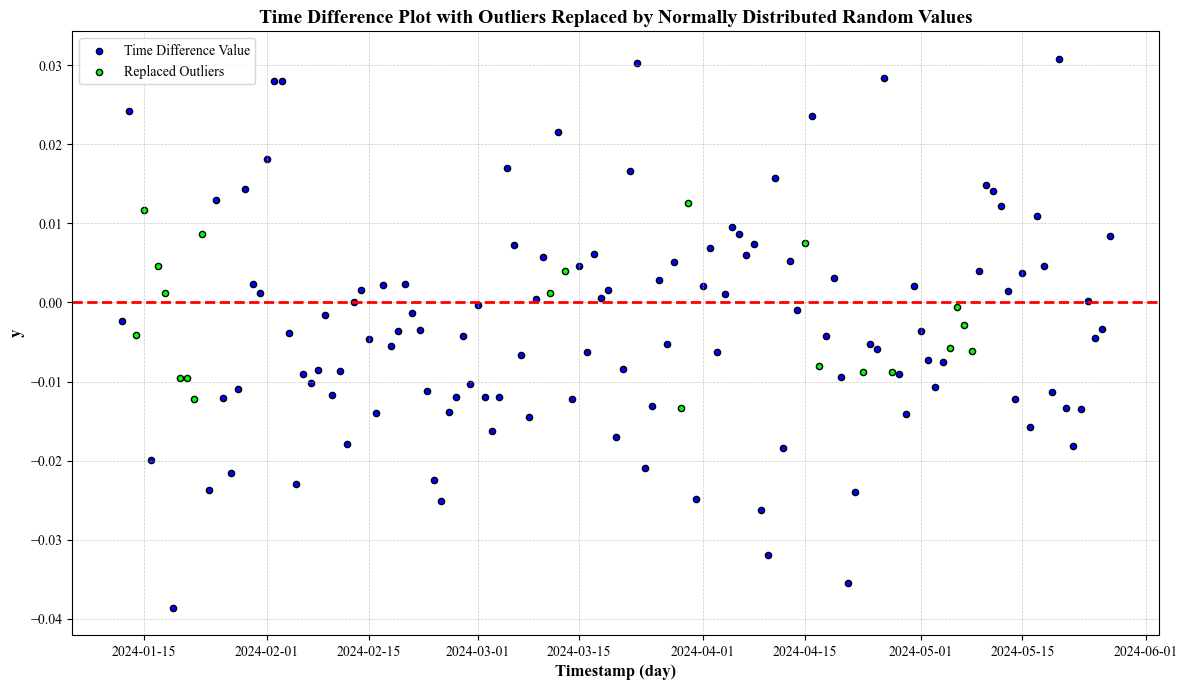

In [10]:
fig6, ax6 = plt.subplots(figsize=(12, 7))
ax6.scatter(corrected_data['ds'].iloc[non_nan_indices], corrected_data['diff_outlier_filled'].iloc[non_nan_indices], marker='o', facecolors='blue', edgecolors='black', alpha=1, s=20, label='Time Difference Value')
ax6.scatter(corrected_data['ds'].iloc[nan_indices], corrected_data['diff_outlier_filled'].iloc[nan_indices], marker='o', facecolors='#00FF00', edgecolors='black', alpha=1, s=20, label='Replaced Outliers')

ax6.axhline(y=0, color='red', linestyle='--', linewidth=2)
ax6.set_xlabel('Timestamp (day)', fontsize=12,fontweight='bold')
ax6.set_ylabel('y', fontsize=12,fontweight='bold')
ax6.set_title('Time Difference Plot with Outliers Replaced by Normally Distributed Random Values', fontsize=14, fontweight='bold')
ax6.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
# ax6.set_ylim(y_diff_min, y_diff_max)
ax6.legend()
plt.tight_layout()
if saveFig:
	fig6.savefig(f'{figPath}fig6.png', dpi=300)
plt.show() 

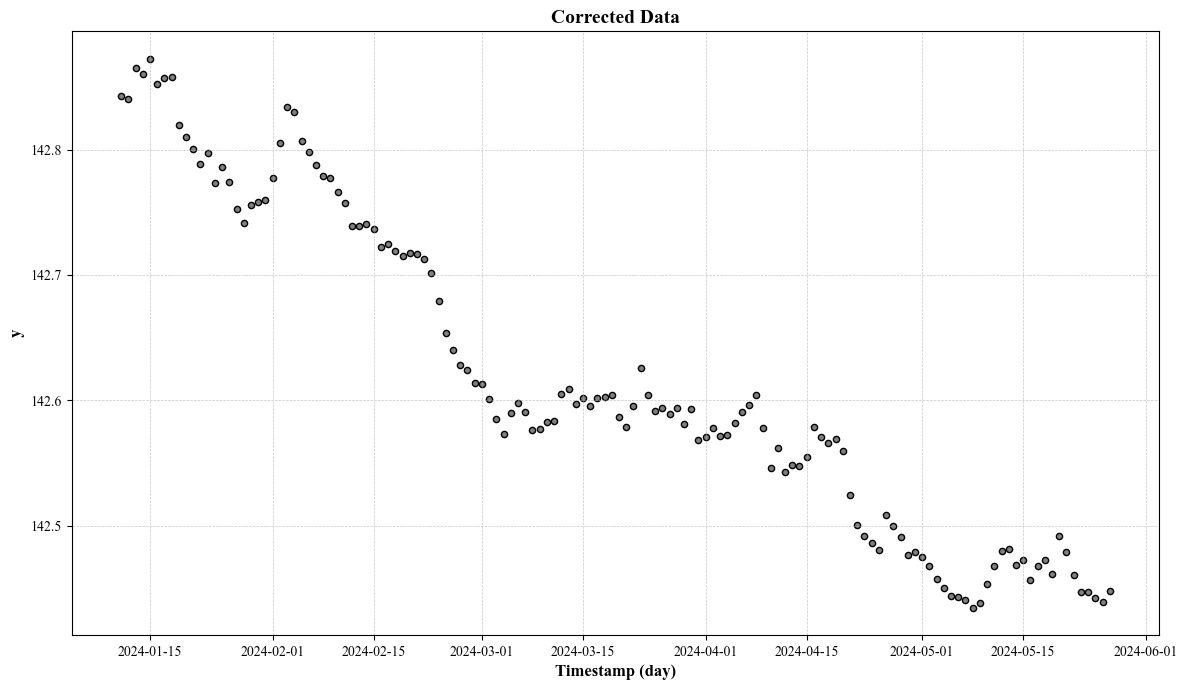

In [11]:
fig7, ax7 = plt.subplots(figsize=(12, 7))
ax7.scatter(corrected_data['ds'], corrected_data['y_corrected'], marker='o', facecolors='gray', edgecolors='black', alpha=1, s=20)
ax7.set_xlabel('Timestamp (day)', fontsize=12,fontweight='bold')
ax7.set_ylabel('y', fontsize=12,fontweight='bold')
ax7.set_title('Corrected Data', fontsize=14, fontweight='bold')
ax7.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
# ax7.set_ylim(y_min, y_max)
plt.tight_layout()
if saveFig:
	fig7.savefig(f'{figPath}fig7.png', dpi=300)
plt.show() 

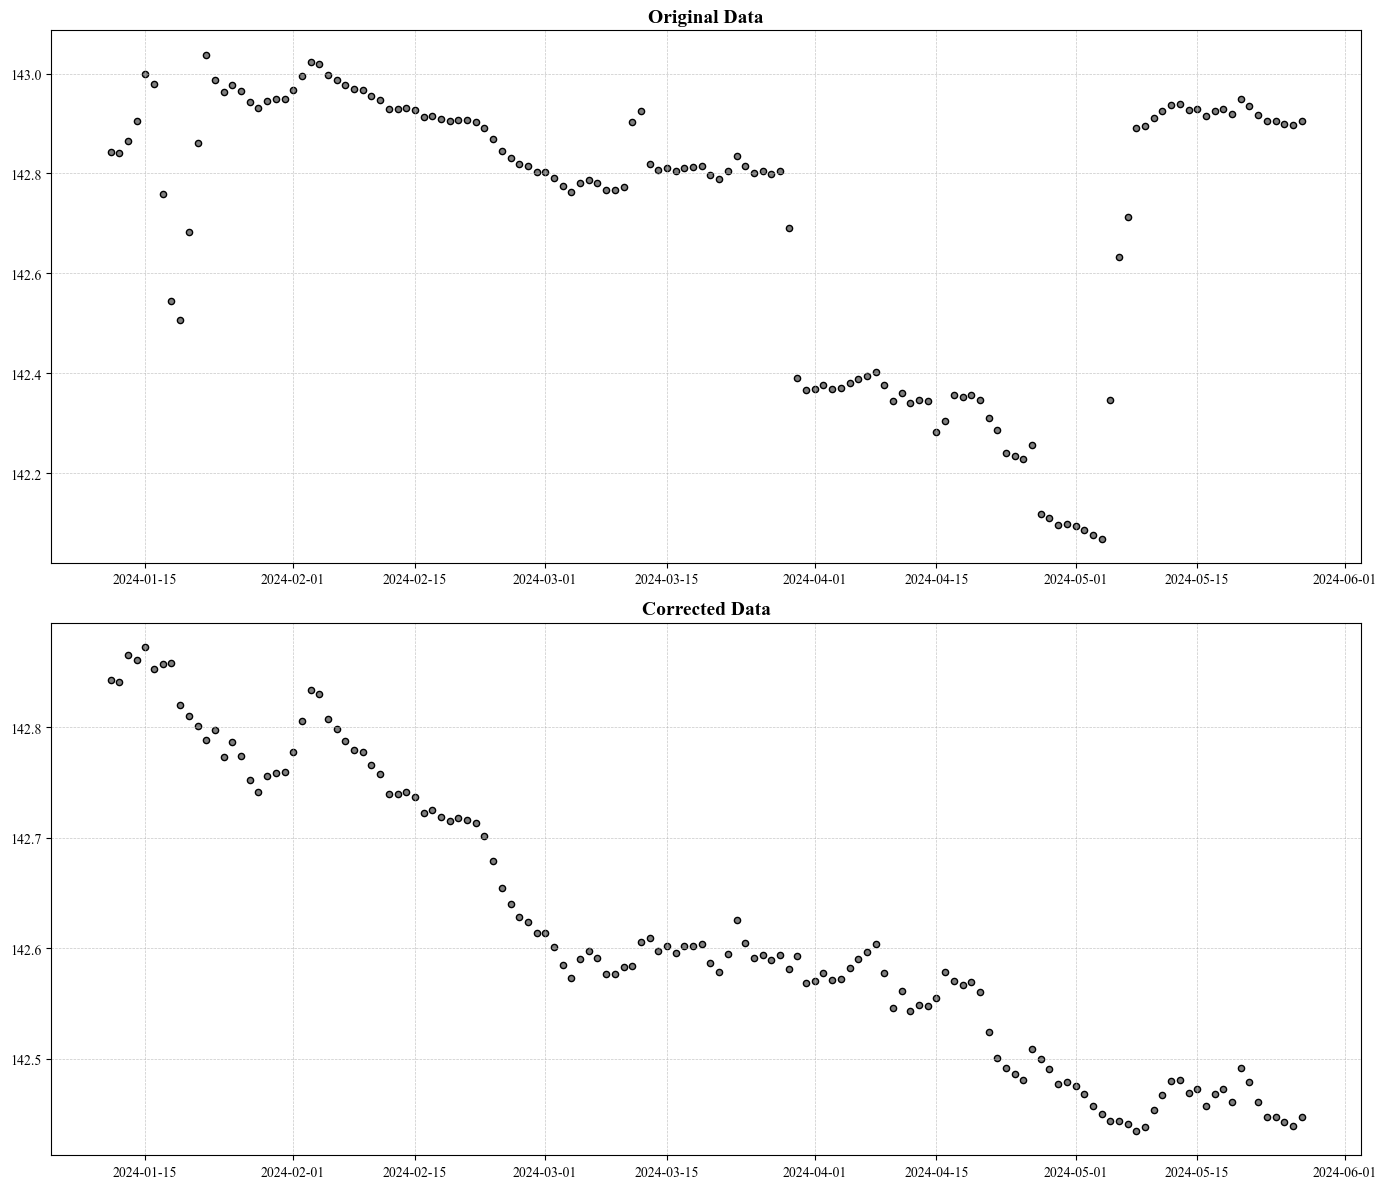

In [12]:
fig8, ax8 = plt.subplots(2, 1, figsize=(14, 12))
ax8[0].scatter(data['ds'], data['y'], marker='o', facecolors='gray', edgecolors='black', alpha=1, s=20)
ax8[0].set_title('Original Data',fontsize=14, fontweight='bold')
ax8[0].grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
# ax8[0].set_ylim(y_min, y_max)
ax8[1].scatter(corrected_data['ds'], corrected_data['y_corrected'], marker='o', facecolors='gray', edgecolors='black', alpha=1, s=20)
ax8[1].set_title('Corrected Data',fontsize=14, fontweight='bold')
ax8[1].grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
# ax8[1].set_ylim(y_min, y_max)

plt.tight_layout()
if saveFig:
	fig8.savefig(f'{figPath}fig8.png', dpi=300)
plt.show()